In [1]:
!python --version

Python 3.11.13


# Web Service Classification using DeepSeek

## Our goal is to build a baseline model with at least 90% accuracy

# 1. Load Python Modules

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,precision_recall_fscore_support
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training

import warnings
import torch
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
%matplotlib inline

sns.set(style="whitegrid")
os.makedirs("charts", exist_ok=True)
os.makedirs("results", exist_ok=True)
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior (optional: slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

cuda


In [3]:
!nvidia-smi

Tue Jul  8 03:22:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:01:00.0 Off |                    0 |
| N/A   43C    P0             53W /  400W |      18MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# 2. Preprocessing

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]

    return " ".join(lemmatized_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 3. Load and Preprocess Dataset

In [5]:
# === Step 1: Load and Preprocess Dataset ===
def load_data(n):
    df = pd.read_csv(f"Balanced_Top_{n}_Web_Services.csv").dropna()
    df = df[['Service Description', 'Grouped Category']].rename(columns={'Service Description': 'text', 'Grouped Category': 'label'})
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    return df, label_encoder.classes_

# 4. Tokenizer and Tokenization

In [6]:
# === Step 2: Tokenizer and Tokenization ===
model_name = "deepseek-ai/deepseek-llm-7b-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# 5. Metric Function

In [7]:
def generate_report_csv(report_dict, confusion_mat, class_labels, class_names, output_file="BERT-Report.csv"):
    df = pd.DataFrame(report_dict).transpose()

    # Filter only the class rows (not avg/macro)
    filtered_labels = [str(class_names[i]) for i in class_labels]
    df = df.loc[filtered_labels].copy()

    # Compute per-class accuracy
    row_sums = confusion_mat.sum(axis=1)
    diagonal = np.diag(confusion_mat)
    per_class_accuracy = (diagonal / row_sums).round(2)

    df['accuracy'] = per_class_accuracy
    if 'support' in df.columns:
        df = df.drop(columns=['support'])

    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Category'}, inplace=True)

    output_path = f"results/{output_file}"
    df.to_csv(output_path, index=False)
    print(f"Classification report saved to: {output_path}")

In [8]:
def plot_confusion_and_report(y_true, y_pred, class_names, n):
    cm = confusion_matrix(y_true, y_pred)
    figsize = (18, 18) if n >= 40 else (8, 8)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - Top {n} Categories")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"charts/BERT_confusion_matrix_top_{n}.png")
    plt.show()

    print(f"classification_report for {n} Web Serivce Categories")
    # Convert class_names to list of strings
    class_names_str = [str(name) for name in class_names]
    
    # Get sorted list of unique label integers
    labels = sorted(np.unique(y_true))

    # classification_report for print
    print(classification_report(y_true, y_pred, target_names=class_names_str, zero_division=0))

    # classification_report for dictionary
    report_dict = classification_report(y_true, y_pred, target_names=class_names_str, output_dict=True, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Save to CSV
    generate_report_csv(report_dict, cm, class_labels=labels, class_names=class_names_str, output_file=f"Deepseek-Report-Top-{n}.csv")

    return report_dict

def plot_metrics(bert_results):
    categories = list(bert_results.keys())
    accuracies = [bert_results[n]['accuracy'] for n in categories]
    precisions = [bert_results[n]['precision'] for n in categories]
    recalls = [bert_results[n]['recall'] for n in categories]
    f1_scores = [bert_results[n]['f1_score'] for n in categories]

    def plot_metric(x, y, ylabel, title, color='blue'):
        plt.figure(figsize=(8, 5))
        plt.plot(x, y, marker='o', linestyle='-', color=color)
        plt.title(title)
        plt.xlabel('Number of Web Serivce Categories')
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.xticks(x)
        plt.tight_layout()
        plt.savefig(f"charts/{title}.png")
        plt.show()

    plot_metric(categories, accuracies, 'Accuracy', 'DeepSeek Model Performace Accuracy', color='green')
    plot_metric(categories, precisions, 'Precision', 'DeepSeek Model Performace Precision', color='orange')
    plot_metric(categories, recalls, 'Recall', 'DeepSeek Model Performace Recall', color='purple')
    plot_metric(categories, f1_scores, 'F1 Score', 'DeepSeek Model Performace F1 Score', color='red')

In [9]:

# === Step 3: Metric Function ===
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average='weighted', zero_division=0),
        "recall": recall_score(labels, preds, average='weighted', zero_division=0),
        "f1": f1_score(labels, preds, average='weighted', zero_division=0)
    }

# 6.PEFT + LoRA Setup

In [10]:
# === Step 4: PEFT + LoRA Setup ===
def get_peft_model_for_classification(num_labels):
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
    )
    model.config.pad_token_id = tokenizer.pad_token_id

    model.gradient_checkpointing_enable()
    model = prepare_model_for_kbit_training(model)

    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=16,
        lora_alpha=32,
        lora_dropout=0.05,
        bias="none"
    )

    return get_peft_model(model, peft_config)

# 7. Training Function

In [11]:
# === Step 5: Training Function ===
def train_lora_classifier(n):
    df, class_names = load_data(n)
    num_labels = len(class_names)

    dataset = Dataset.from_pandas(df[['text', 'label']])
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    tokenized = dataset.map(tokenize_function, batched=True)
    tokenized = tokenized.remove_columns(["text"])

    model = get_peft_model_for_classification(num_labels)

    training_args = TrainingArguments(
        output_dir=f"./results_lora_deepseek_top_{n}",
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,
        num_train_epochs=10,
        learning_rate=2e-4,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=10,
        save_total_limit=2,
        load_best_model_at_end=True,
        report_to="none",
        fp16=True
    )

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["test"],
        compute_metrics=compute_metrics,
    )

    trainer.train()
    preds = trainer.predict(tokenized['test'])
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    # Metrics and reports
    metrics = compute_metrics((preds.predictions, y_true))
    report = plot_confusion_and_report(y_true, y_pred, class_names, n)
    model_dir = f"./web_sevice_trained_deepseek_model"
    os.makedirs(model_dir, exist_ok=True)

    # Save model and tokenizer
    trainer.save_model(model_dir)
    tokenizer.save_pretrained(model_dir)

    return {
        "accuracy": metrics["accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1_score": metrics["f1"]
    }

# 8 . Call Train

Map:   0%|          | 0/7995 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/deepseek-llm-7b-base and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[2025-07-08 03:22:48,602] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/root/miniconda3/envs/py3.11/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/py3.11/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/py3.11/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/py3.11/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/py3.11/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/root/miniconda3/envs/py3.11/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/root/miniconda3/envs/py3.11/compiler_compat/ld: /u

[2025-07-08 03:22:49,661] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.602800,0.783851,0.774887,0.790138,0.774887,0.767272
2,0.427800,0.633122,0.832416,0.834051,0.832416,0.829080
3,0.223500,0.620687,0.861431,0.862070,0.861431,0.858675
4,0.081300,0.635061,0.863932,0.867949,0.863932,0.862997
5,0.005400,0.690748,0.867434,0.868432,0.867434,0.865971
6,0.000900,0.708718,0.870935,0.871606,0.870935,0.869433
7,0.000400,0.756296,0.866433,0.866876,0.866433,0.864706
8,0.000300,0.779895,0.866433,0.866138,0.866433,0.864041
9,0.000300,0.790364,0.864932,0.864619,0.864932,0.862744
10,0.000200,0.799840,0.866433,0.865481,0.866433,0.863744


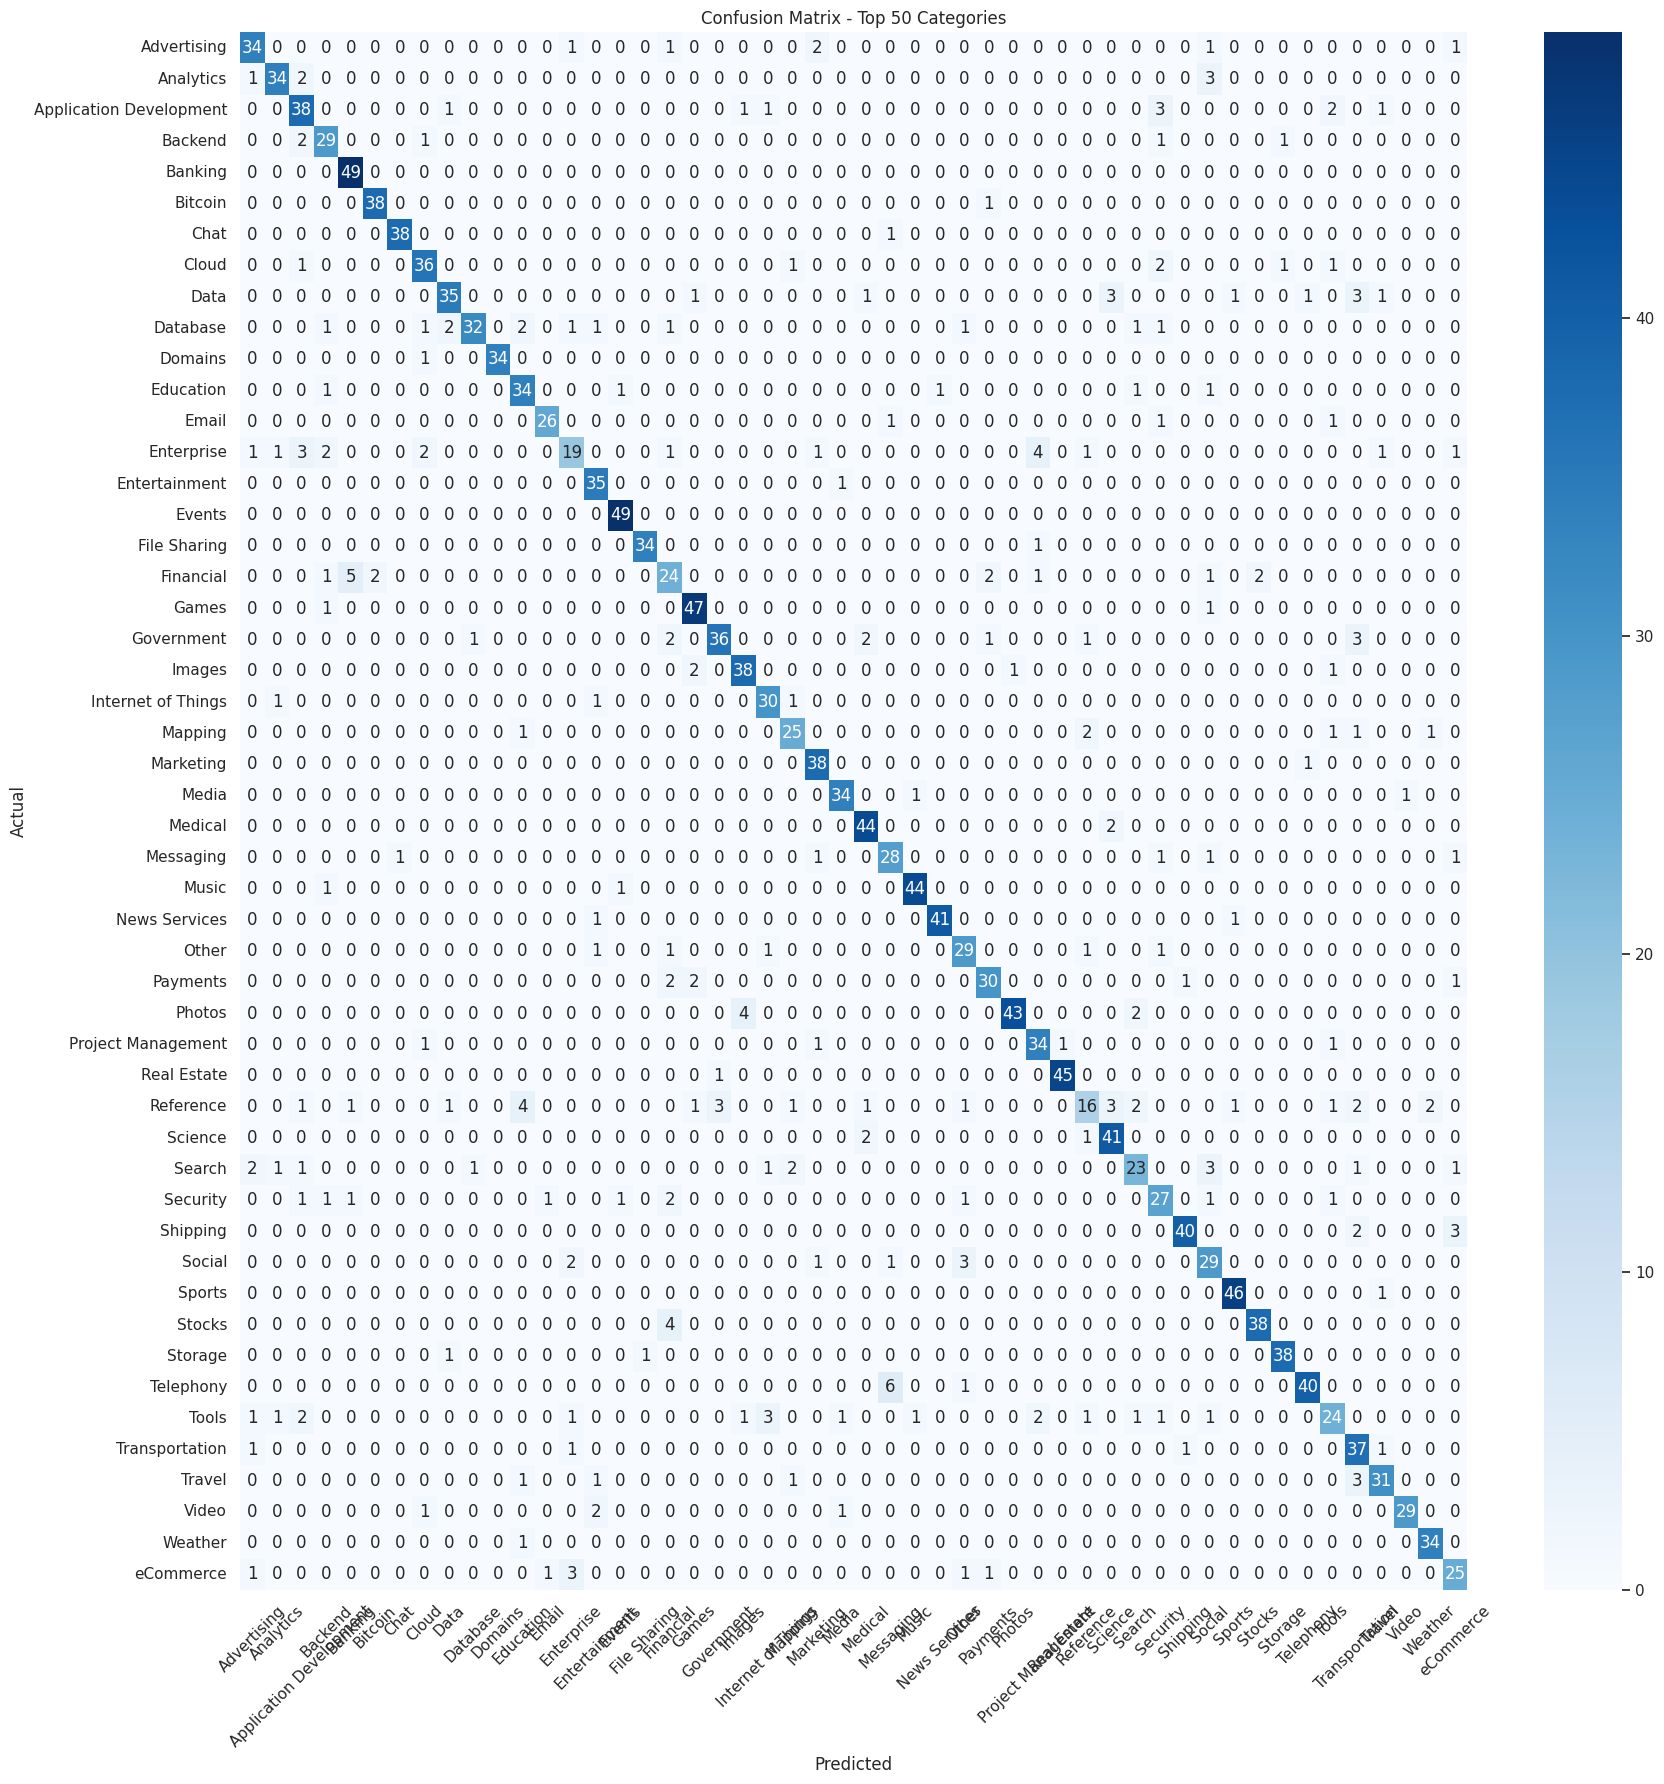

classification_report for 50 Web Serivce Categories
                         precision    recall  f1-score   support

            Advertising       0.83      0.85      0.84        40
              Analytics       0.89      0.85      0.87        40
Application Development       0.75      0.81      0.78        47
                Backend       0.78      0.85      0.82        34
                Banking       0.88      1.00      0.93        49
                Bitcoin       0.95      0.97      0.96        39
                   Chat       0.97      0.97      0.97        39
                  Cloud       0.84      0.86      0.85        42
                   Data       0.88      0.76      0.81        46
               Database       0.94      0.73      0.82        44
                Domains       1.00      0.97      0.99        35
              Education       0.79      0.87      0.83        39
                  Email       0.93      0.90      0.91        29
             Enterprise       0.68   

In [12]:
import torch
deepseek_results = []
result = train_lora_classifier(50)
print(result)
deepseek_results.append(result)
     

# 7. Performance and Plots

[{'accuracy': 0.8614307153576788, 'precision': np.float64(0.8620704516926024), 'recall': np.float64(0.8614307153576788), 'f1_score': np.float64(0.858675056356571)}]


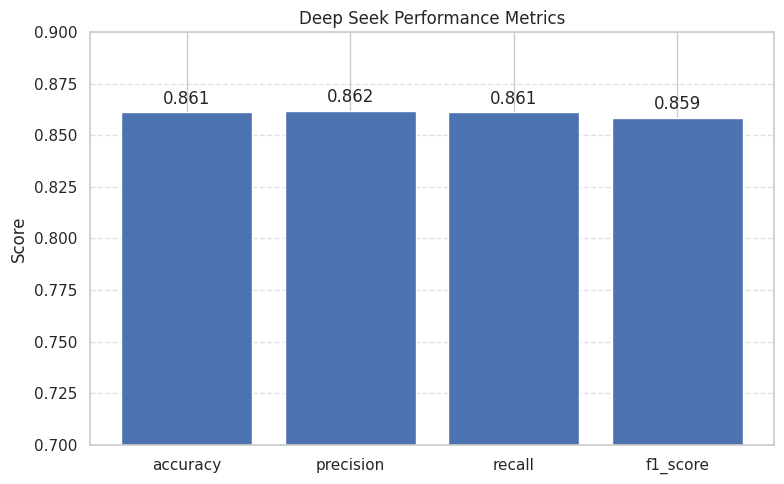

In [13]:
# Plot metrics

print(deepseek_results)
import matplotlib.pyplot as plt

# Plot settings
for metric_dict in deepseek_results:
    #model_name = metric_dict['model']
    metrics = {k: v for k, v in metric_dict.items() if k != 'model'}

    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics.values())
    
    # Labels and title
    plt.ylabel('Score')
    plt.ylim(0.7, 0.9)  # Adjust range as needed
    plt.title(f'Deep Seek Performance Metrics')

    # Annotate bar values
    for key, value in metrics.items():
        plt.text(key, value + 0.002, f"{value:.3f}", ha='center', va='bottom')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()